### https://medium.com/@quantclubiitkgp/stock-buy-sell-hold-prediction-using-cnn-ee7b671f4ad3

In [80]:
import pandas as pd
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt

In [6]:
company_code = 'WMT'
Dataset_dir = 'stock_history'
work_type = 'stock_cnn_blog_pub-master'
root_path = Path(os.getcwd())
dataset_path = os.path.join(root_path, work_type, Dataset_dir, company_code, company_code + ".csv")

In [7]:
dataset_path

'D:\\git_repos\\AI_NLP_Journey\\CNN Timeseries to Image classification\\stock_cnn_blog_pub-master\\stock_history\\WMT\\WMT.csv'

In [8]:
df =pd.read_csv(dataset_path)

In [10]:
df.drop(columns=['dividend_amount', 'split_coefficient'], inplace=True)
df

,timestamp,open,high,low,close,adjusted_close,volume
0,2020-01-10,117.24,117.340,115.9800,116.38,116.3800,6054752
1,2020-01-09,116.15,117.370,116.0806,117.36,117.3600,5563504
2,2020-01-08,116.30,116.730,115.6800,116.16,116.1600,5875310
3,2020-01-07,117.26,117.515,116.2000,116.56,116.5600,6849343
4,2020-01-06,117.40,118.090,116.7700,117.65,117.6500,6438004
...,...,...,...,...,...,...,...
5028,2000-01-14,64.00,65.940,64.0000,64.50,44.7950,6312200
5029,2000-01-13,66.00,66.130,65.0000,65.13,45.2325,5021000
5030,2000-01-12,66.19,66.750,65.0600,65.06,45.1839,4085000
5031,2000-01-11,67.06,67.750,65.6300,66.25,46.0104,4943300


<Axes: >

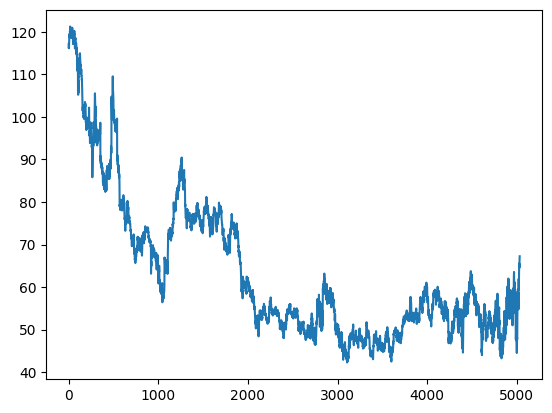

In [11]:
df.close.plot()

In [24]:
df.rename(columns={'open':'Open', 'high':'High', 'low':'Low', 'close':'Close', 'volume':'Volume'}, inplace=True)

In [25]:
df

,timestamp,Open,High,Low,Close,adjusted_close,Volume
0,2020-01-10,117.24,117.340,115.9800,116.38,116.3800,6054752
1,2020-01-09,116.15,117.370,116.0806,117.36,117.3600,5563504
2,2020-01-08,116.30,116.730,115.6800,116.16,116.1600,5875310
3,2020-01-07,117.26,117.515,116.2000,116.56,116.5600,6849343
4,2020-01-06,117.40,118.090,116.7700,117.65,117.6500,6438004
...,...,...,...,...,...,...,...
5028,2000-01-14,64.00,65.940,64.0000,64.50,44.7950,6312200
5029,2000-01-13,66.00,66.130,65.0000,65.13,45.2325,5021000
5030,2000-01-12,66.19,66.750,65.0600,65.06,45.1839,4085000
5031,2000-01-11,67.06,67.750,65.6300,66.25,46.0104,4943300


In [26]:
data = df

In [61]:
# Initialize the output DataFrame
indicators_df = data.copy()

# Moving Averages (Simple and Exponential)
for window in [5, 10, 20, 50, 100, 200]:
    indicators_df[f'SMA_{window}'] = indicators_df['Close'].rolling(window=window).mean()
    indicators_df[f'EMA_{window}'] = indicators_df['Close'].ewm(span=window, adjust=False).mean()

# Momentum Indicators
indicators_df['RSI_14'] = 100 - (100 / (1 + (indicators_df['Close'].diff().clip(lower=0).rolling(window=14).mean() / 
                                              indicators_df['Close'].diff().clip(upper=0).abs().rolling(window=14).mean())))

indicators_df['Stochastic_K'] = ((indicators_df['Close'] - indicators_df['Low'].rolling(14).min()) /
                                  (indicators_df['High'].rolling(14).max() - indicators_df['Low'].rolling(14).min())) * 100

indicators_df['Stochastic_D'] = indicators_df['Stochastic_K'].rolling(3).mean()

# Williams %R
indicators_df['Williams_%R'] = ((indicators_df['High'].rolling(14).max() - indicators_df['Close']) /
                                 (indicators_df['High'].rolling(14).max() - indicators_df['Low'].rolling(14).min())) * -100

# Moving Average Convergence Divergence (MACD)
indicators_df['MACD'] = indicators_df['Close'].ewm(span=12, adjust=False).mean() - indicators_df['Close'].ewm(span=26, adjust=False).mean()
indicators_df['MACD_Signal'] = indicators_df['MACD'].ewm(span=9, adjust=False).mean()
indicators_df['MACD_Hist'] = indicators_df['MACD'] - indicators_df['MACD_Signal']

# Average Directional Index (ADX)
high_diff = indicators_df['High'].diff()
low_diff = indicators_df['Low'].diff()
plus_dm = np.where((high_diff > low_diff) & (high_diff > 0), high_diff, 0)
minus_dm = np.where((low_diff > high_diff) & (low_diff > 0), low_diff, 0)
true_range = pd.DataFrame({
    'hl': indicators_df['High'] - indicators_df['Low'],
    'hc': (indicators_df['High'] - indicators_df['Close'].shift()).abs(),
    'lc': (indicators_df['Low'] - indicators_df['Close'].shift()).abs()
}).max(axis=1)
indicators_df['ATR'] = true_range.rolling(window=14).mean()
indicators_df['Plus_DI'] = 100 * pd.Series(plus_dm).rolling(window=14).mean() / indicators_df['ATR']
indicators_df['Minus_DI'] = 100 * pd.Series(minus_dm).rolling(window=14).mean() / indicators_df['ATR']
indicators_df['ADX'] = 100 * abs(indicators_df['Plus_DI'] - indicators_df['Minus_DI']).rolling(window=14).mean() / (indicators_df['Plus_DI'] + indicators_df['Minus_DI'])

# Commodity Channel Index (CCI)
typical_price = (indicators_df['High'] + indicators_df['Low'] + indicators_df['Close']) / 3
indicators_df['CCI'] = (typical_price - typical_price.rolling(20).mean()) / (0.015 * typical_price.rolling(20).std())

# Bollinger Bands
indicators_df['Bollinger_Mid'] = indicators_df['Close'].rolling(window=20).mean()
indicators_df['Bollinger_Upper'] = indicators_df['Bollinger_Mid'] + 2 * indicators_df['Close'].rolling(window=20).std()
indicators_df['Bollinger_Lower'] = indicators_df['Bollinger_Mid'] - 2 * indicators_df['Close'].rolling(window=20).std()

# Rate of Change (ROC)
indicators_df['ROC'] = indicators_df['Close'].pct_change(periods=12) * 100

# On-Balance Volume (OBV)
obv = np.where(indicators_df['Close'] > indicators_df['Close'].shift(1), indicators_df['Volume'],
               np.where(indicators_df['Close'] < indicators_df['Close'].shift(1), -indicators_df['Volume'], 0))
indicators_df['OBV'] = obv.cumsum()

# Force Index
indicators_df['Force_Index'] = indicators_df['Close'].diff(1) * indicators_df['Volume']

# Accumulation/Distribution Line (ADL)
adl = ((indicators_df['Close'] - indicators_df['Low']) - (indicators_df['High'] - indicators_df['Close'])) / \
       (indicators_df['High'] - indicators_df['Low']) * indicators_df['Volume']
indicators_df['ADL'] = adl.cumsum()

# Money Flow Index (MFI)
money_flow = typical_price * indicators_df['Volume']
positive_flow = np.where(typical_price > typical_price.shift(1), money_flow, 0)
negative_flow = np.where(typical_price < typical_price.shift(1), money_flow, 0)
mfi_ratio = pd.Series(positive_flow).rolling(14).sum() / pd.Series(negative_flow).rolling(14).sum()
indicators_df['MFI'] = 100 - (100 / (1 + mfi_ratio))

# Accumulation Swing Index (ASI)
indicators_df['ASI'] = ((indicators_df['Close'] - indicators_df['Close'].shift()) +
                        (0.5 * (indicators_df['Close'] - indicators_df['Open'])) +
                        (0.25 * (indicators_df['Close'].shift() - indicators_df['Open'].shift()))) / indicators_df['ATR']

# Chaikin Oscillator
indicators_df['Chaikin_Oscillator'] = indicators_df['ADL'].ewm(span=3, adjust=False).mean() - indicators_df['ADL'].ewm(span=10, adjust=False).mean()


In [62]:
len(indicators_df.columns)

41

In [63]:
indicators_df

,timestamp,Open,High,Low,Close,adjusted_close,Volume,SMA_5,EMA_5,SMA_10,...,Bollinger_Mid,Bollinger_Upper,Bollinger_Lower,ROC,OBV,Force_Index,ADL,MFI,ASI,Chaikin_Oscillator
0,2020-01-10,117.24,117.340,115.9800,116.38,116.3800,6054752,NaN,116.380000,NaN,...,NaN,NaN,NaN,NaN,0,NaN,-2.493133e+06,NaN,NaN,0.000000e+00
1,2020-01-09,116.15,117.370,116.0806,117.36,117.3600,5563504,NaN,116.706667,NaN,...,NaN,NaN,NaN,NaN,5563504,5452233.92,2.984075e+06,NaN,NaN,1.742748e+06
2,2020-01-08,116.30,116.730,115.6800,116.16,116.1600,5875310,NaN,116.524444,NaN,...,NaN,NaN,NaN,NaN,-311806,-7050372.00,2.480477e+06,NaN,NaN,2.137023e+06
3,2020-01-07,117.26,117.515,116.2000,116.56,116.5600,6849343,NaN,116.536296,NaN,...,NaN,NaN,NaN,NaN,6537537,2739737.20,-6.186556e+05,NaN,NaN,1.117955e+06
4,2020-01-06,117.40,118.090,116.7700,117.65,117.6500,6438004,116.822,116.907531,NaN,...,NaN,NaN,NaN,NaN,12975541,7017424.36,1.527346e+06,NaN,NaN,1.282250e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5028,2000-01-14,64.00,65.940,64.0000,64.50,44.7950,6312200,63.988,63.767986,61.665,...,59.4640,66.032725,52.895275,10.483042,-1135417023,-6690932.00,-8.926628e+08,63.411561,-0.059870,-2.831069e+06
5029,2000-01-13,66.00,66.130,65.0000,65.13,45.2325,5021000,64.526,64.221991,62.665,...,59.9175,66.744024,53.090976,10.972909,-1130396023,3163230.00,-8.965285e+08,62.938969,0.089726,-4.018509e+06
5030,2000-01-12,66.19,66.750,65.0600,65.06,45.1839,4085000,64.862,64.501327,63.258,...,60.3205,67.369831,53.271169,18.831050,-1134481023,-285950.00,-9.006135e+08,62.390574,-0.239322,-5.438733e+06
5031,2000-01-11,67.06,67.750,65.6300,66.25,46.0104,4943300,65.300,65.084218,63.689,...,60.7425,68.159930,53.325070,20.170506,-1129537723,5882527.00,-9.026654e+08,69.897731,0.146562,-6.178193e+06


In [65]:
df_processed = indicators_df.dropna().reset_index()

In [130]:
df_processed

,index,timestamp,Open,High,Low,Close,adjusted_close,Volume,SMA_5,EMA_5,...,Bollinger_Mid,Bollinger_Upper,Bollinger_Lower,ROC,OBV,Force_Index,ADL,MFI,ASI,Chaikin_Oscillator
0,199,2019-03-28,97.59,97.87,96.53,97.13,95.7185,8054324,97.322,97.563511,...,100.3810,105.373862,95.388138,-5.174265,-176840075,-3221729.60,-4.209025e+06,25.265668,-0.458143,1.965101e+06
1,200,2019-03-27,98.14,98.86,96.96,97.21,95.7973,8471172,97.326,97.445674,...,100.0655,105.020504,95.110496,-4.283182,-168368903,677693.76,-1.045094e+07,34.374394,-0.337187,-3.765671e+05
2,201,2019-03-26,98.36,98.85,98.03,98.32,96.8912,4946289,97.602,97.737116,...,99.8050,104.535842,95.074158,-2.460317,-163422614,5490380.79,-1.189864e+07,40.510713,0.579112,-1.760919e+06
3,202,2019-03-25,97.80,98.62,97.63,98.17,96.7434,5407425,97.672,97.881411,...,99.5600,104.081798,95.038202,-1.435743,-168830039,-811113.75,-1.140705e+07,40.477841,0.017250,-2.010748e+06
4,203,2019-03-22,98.58,99.53,97.94,98.28,96.8518,6708131,97.822,98.014274,...,99.3555,103.709022,95.001978,-0.415442,-162121908,737894.41,-1.524630e+07,48.021873,0.037140,-3.151734e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4823,5028,2000-01-14,64.00,65.94,64.00,64.50,44.7950,6312200,63.988,63.767986,...,59.4640,66.032725,52.895275,10.483042,-1135417023,-6690932.00,-8.926628e+08,63.411561,-0.059870,-2.831069e+06
4824,5029,2000-01-13,66.00,66.13,65.00,65.13,45.2325,5021000,64.526,64.221991,...,59.9175,66.744024,53.090976,10.972909,-1130396023,3163230.00,-8.965285e+08,62.938969,0.089726,-4.018509e+06
4825,5030,2000-01-12,66.19,66.75,65.06,65.06,45.1839,4085000,64.862,64.501327,...,60.3205,67.369831,53.271169,18.831050,-1134481023,-285950.00,-9.006135e+08,62.390574,-0.239322,-5.438733e+06
4826,5031,2000-01-11,67.06,67.75,65.63,66.25,46.0104,4943300,65.300,65.084218,...,60.7425,68.159930,53.325070,20.170506,-1129537723,5882527.00,-9.026654e+08,69.897731,0.146562,-6.178193e+06


In [131]:
predicted_prices = df_processed.SMA_10.values

In [132]:
def signals_generator(predicted_prices, time_steps, price_diff_new_signal = 0.0030 ):
    # Provided predicted price array
    # predicted_prices = np.array([1.07741435, 1.07797974, 1.07768342, 1.07768771, 1.07819248,
    #                              1.07827098, 1.07808965, 1.07778313, 1.07765595, 1.07710098,
    #                              1.07924897, 1.08013435, 1.0815506, 1.08151388, 1.08143381])

    # Define EMA parameters
    n = time_steps  # Number of periods
    alpha = 2 / (n + 1)

    # Calculate EMA using np.convolve
    ema = np.zeros_like(predicted_prices)
    ema[0] = predicted_prices[0]  # First EMA value is the first price

    for i in range(1, len(predicted_prices)):
        ema[i] = alpha * predicted_prices[i] + (1 - alpha) * ema[i-1]

    # Initialize signals
    signals = np.zeros(len(predicted_prices))

    # Generate signals based on EMA crossover
    for i in range(1, len(predicted_prices)):
        if predicted_prices[i] > ema[i] and predicted_prices[i-1] <= ema[i-1]:
            signals[i] = 1  # Buy signal
        elif predicted_prices[i] < ema[i] and predicted_prices[i-1] >= ema[i-1]:
            signals[i] = 2  # Sell signal
        else:
            signals[i] = 0  # Hold signal

    start = 0
    end = len(signals) - 1
    important_points = []

    for i in range(len(signals)):
        j = i + 1
        if signals[i] == 1:
            while j < len(signals) and signals[j] == 1:
                signals[j] = 0
                j += 1
        elif signals[i] == 2:
            while j < len(signals) and signals[j] == 2:
                signals[j] = 0
                j += 1

    # Print predicted prices at start, buy/sell signals, and end
    start = 0
    end = len(signals) - 1
    important_points = []


    for i in range(len(signals)):
        if i == start or i == end or signals[i] != 0:
            important_points.append((i, predicted_prices[i]))


    pip_change_min = price_diff_new_signal        
    # Calculate and print percentage changes
    for j in range(1, len(important_points)):
        index_prev, price_prev = important_points[j - 1]
        index_curr, price_curr = important_points[j]
    #     percent_change = ((price_curr - price_prev) / price_prev) * 100
        pip_change = (price_curr - price_prev)
        if pip_change_min < abs(pip_change):
            # print(f"Change from index {index_prev} to {index_curr}: {pip_change:.4f}")
            pass

        else:
            signals[index_prev] = 0
    #         signals[index_curr] = 0
    return signals

In [135]:
signals = signals_generator(predicted_prices, 30, 0.01)

np.unique(signals, return_counts=True)

(array([0., 1., 2.]), array([4667,   80,   81], dtype=int64))

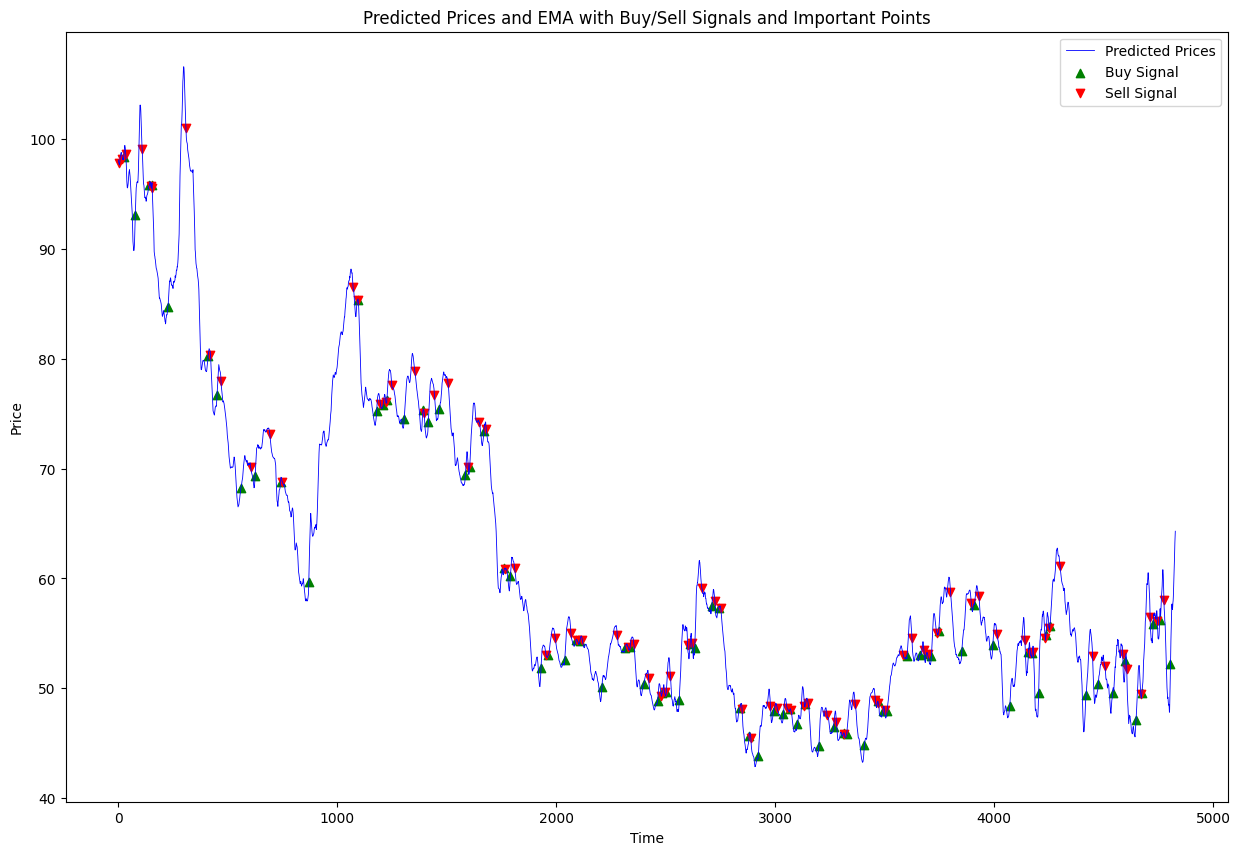

In [136]:
# Plot the results
plt.figure(figsize=(15, 10))
plt.plot(predicted_prices, linewidth=0.6, color='blue', label='Predicted Prices', )
# plt.plot(df_h4['avg'].values[-length:], color='red', linewidth=0.3, label='Actaul Prices')
# plt.plot(ema, label='EMA', linestyle='--', color='green', linewidth=0.3)
plt.scatter(np.arange(len(predicted_prices)), np.where(signals == 1, predicted_prices, np.nan), marker='^', color='g', label='Buy Signal')
plt.scatter(np.arange(len(predicted_prices)), np.where(signals == 2, predicted_prices, np.nan), marker='v', color='r', label='Sell Signal')

# Annotate the important points
# for index, price in important_points:
#     plt.annotate(f'{price:.5f}', (index, price),
#                  textcoords="offset points", xytext=(0,10), ha='center', color='blue')

plt.legend()
plt.title('Predicted Prices and EMA with Buy/Sell Signals and Important Points')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

In [140]:
print(len(predicted_prices), len(df_processed), len(signals))

4828 4828 4828


In [141]:
type(signals)

numpy.ndarray

In [144]:
df_processed['labels'] = pd.Series(signals)
df_processed['labels'] = df_processed['labels'].astype(np.int8)

In [145]:
df_processed

,index,timestamp,Open,High,Low,Close,adjusted_close,Volume,SMA_5,EMA_5,...,Bollinger_Upper,Bollinger_Lower,ROC,OBV,Force_Index,ADL,MFI,ASI,Chaikin_Oscillator,labels
0,199,2019-03-28,97.59,97.87,96.53,97.13,95.7185,8054324,97.322,97.563511,...,105.373862,95.388138,-5.174265,-176840075,-3221729.60,-4.209025e+06,25.265668,-0.458143,1.965101e+06,0
1,200,2019-03-27,98.14,98.86,96.96,97.21,95.7973,8471172,97.326,97.445674,...,105.020504,95.110496,-4.283182,-168368903,677693.76,-1.045094e+07,34.374394,-0.337187,-3.765671e+05,2
2,201,2019-03-26,98.36,98.85,98.03,98.32,96.8912,4946289,97.602,97.737116,...,104.535842,95.074158,-2.460317,-163422614,5490380.79,-1.189864e+07,40.510713,0.579112,-1.760919e+06,0
3,202,2019-03-25,97.80,98.62,97.63,98.17,96.7434,5407425,97.672,97.881411,...,104.081798,95.038202,-1.435743,-168830039,-811113.75,-1.140705e+07,40.477841,0.017250,-2.010748e+06,0
4,203,2019-03-22,98.58,99.53,97.94,98.28,96.8518,6708131,97.822,98.014274,...,103.709022,95.001978,-0.415442,-162121908,737894.41,-1.524630e+07,48.021873,0.037140,-3.151734e+06,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4823,5028,2000-01-14,64.00,65.94,64.00,64.50,44.7950,6312200,63.988,63.767986,...,66.032725,52.895275,10.483042,-1135417023,-6690932.00,-8.926628e+08,63.411561,-0.059870,-2.831069e+06,0
4824,5029,2000-01-13,66.00,66.13,65.00,65.13,45.2325,5021000,64.526,64.221991,...,66.744024,53.090976,10.972909,-1130396023,3163230.00,-8.965285e+08,62.938969,0.089726,-4.018509e+06,0
4825,5030,2000-01-12,66.19,66.75,65.06,65.06,45.1839,4085000,64.862,64.501327,...,67.369831,53.271169,18.831050,-1134481023,-285950.00,-9.006135e+08,62.390574,-0.239322,-5.438733e+06,0
4826,5031,2000-01-11,67.06,67.75,65.63,66.25,46.0104,4943300,65.300,65.084218,...,68.159930,53.325070,20.170506,-1129537723,5882527.00,-9.026654e+08,69.897731,0.146562,-6.178193e+06,0


In [ ]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from collections import Counter

list_features = list(df.loc[:, 'open':'eom_26'].columns)
print('Total number of features', len(list_features))
x_train, x_test, y_train, y_test = train_test_split(df.loc[:, 'open':'eom_26'].values, df['labels'].values, train_size=0.8, 
                                                    test_size=0.2, random_state=2, shuffle=True, stratify=df['labels'].values)

# smote = RandomOverSampler(random_state=42, sampling_strategy='not majority')
# x_train, y_train = smote.fit_resample(x_train, y_train)
# print('Resampled dataset shape %s' % Counter(y_train))

if 0.7*x_train.shape[0] < 2500:
    train_split = 0.8
else:
    train_split = 0.7
# train_split = 0.7
print('train_split =',train_split)
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, train_size=train_split, test_size=1-train_split, 
                                                random_state=2, shuffle=True, stratify=y_train)
mm_scaler = MinMaxScaler(feature_range=(0, 1)) # or StandardScaler?
x_train = mm_scaler.fit_transform(x_train)
x_cv = mm_scaler.transform(x_cv)
x_test = mm_scaler.transform(x_test)

x_main = x_train.copy()
print("Shape of x, y train/cv/test {} {} {} {} {} {}".format(x_train.shape, y_train.shape, x_cv.shape, y_cv.shape, x_test.shape, y_test.shape))